In [ ]:
from google.colab import drive


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import random
# Define constants
IMG_SIZE = (224, 224)
NUM_FRAMES = 10
BATCH_SIZE = 5
EPOCHS = 10

# Function to extract frames from videos and resize them
def extract_frames(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)
    while len(frames) < NUM_FRAMES:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, IMG_SIZE)
        frames.append(frame)
    cap.release()
    return np.array(frames)

# Load video data and labels
data = []
labels = []
video_folder_positive = "/content/drive/MyDrive/CapstoneTeam_115/Dachcam_dataset/videos/training/pos100"
video_folder_negative = "/content/drive/MyDrive/CapstoneTeam_115/Dachcam_dataset/videos/training/neg100"

for video_file in os.listdir(video_folder_positive):
    if video_file.endswith(".mp4"):
        frames = extract_frames(os.path.join(video_folder_positive, video_file))
        if len(frames) == NUM_FRAMES:
            data.append(frames)
            labels.append(1)  # Positive label

for video_file in os.listdir(video_folder_negative):
    if video_file.endswith(".mp4"):
        frames = extract_frames(os.path.join(video_folder_negative, video_file))
        if len(frames) == NUM_FRAMES:
            data.append(frames)
            labels.append(0)  # Negative label

data = np.array(data)
labels = np.array(labels)

# Split the data into train and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(data, labels, test_size=0.2, random_state=42)

# Preprocess the frames
x_train = x_train / 255.0  # Normalize pixel values to [0, 1]
x_valid = x_valid / 255.0

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2

# Define a custom model with MobileNetV2 as the backbone
def vit_model(input_shape, num_classes):
    # Create an Input layer for the sequence of frames
    input_layer = layers.Input(shape=input_shape)

    # Use MobileNetV2 as the backbone
    backbone = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = layers.TimeDistributed(backbone)(input_layer)

    # Reshape to flatten the frames
    x = layers.Reshape((NUM_FRAMES, -1))(x)

    # Apply multi-head self-attention
    num_heads = 2 # You can adjust this number
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=128, value_dim=128)(x, x)

    # Add feed-forward layer
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.1)(x)  # You can adjust the dropout rate

    # Apply Global Average Pooling to get a single feature vector for each frame
    x = layers.GlobalAveragePooling1D()(x)

    # Output layer with a sigmoid activation for binary classification
    output = layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=output)

    return model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Define the number of classes
num_classes = 2

# Create the custom ViT model
input_shape = (NUM_FRAMES, IMG_SIZE[0], IMG_SIZE[1], 3)
model = vit_model(input_shape, num_classes)

# Compile the model with binary cross-entropy loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)



model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_valid, y_valid))

Epoch 1/10
32/32 [==============================] - 50s 377ms/step - loss: 1.3160 - accuracy: 0.5000 - val_loss: 0.6922 - val_accuracy: 0.5500
Epoch 2/10
32/32 [==============================] - 10s 307ms/step - loss: 0.9295 - accuracy: 0.5625 - val_loss: 0.8374 - val_accuracy: 0.5250
Epoch 3/10
32/32 [==============================] - 10s 312ms/step - loss: 0.5658 - accuracy: 0.7437 - val_loss: 1.2140 - val_accuracy: 0.5250
Epoch 4/10
32/32 [==============================] - 11s 333ms/step - loss: 0.3756 - accuracy: 0.8687 - val_loss: 1.5812 - val_accuracy: 0.4500
Epoch 5/10
32/32 [==============================] - 10s 313ms/step - loss: 0.1391 - accuracy: 0.9438 - val_loss: 1.9027 - val_accuracy: 0.4750
Epoch 6/10
32/32 [==============================] - 10s 312ms/step - loss: 0.0987 - accuracy: 0.9875 - val_loss: 4.0998 - val_accuracy: 0.4500
Epoch 7/10
32/32 [==============================] - 10s 316ms/step - loss: 0.1236 - accuracy: 0.9750 - val_loss: 2.6374 - val_accuracy: 0.4750

In [ ]:

import datetime
import tensorflow_hub as hub

In [ ]:
IMG_SIZE=224

def process_image(image_path):
  image=tf.io.read_file(image_path)
  image=tf.image.decode_jpeg(image,channels=3)
  image=tf.image.convert_image_dtype(image,tf.float32)
  image=tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])
  return image

In [ ]:
def save_model(model,suffix=None):
    modeldir=os.path.join("/content/drive/MyDrive/CapstoneTeam_115",datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
    model_path=modeldir + "-" + suffix + ".h5"
    model.save(model_path)
    return model_path

In [ ]:
def load_model(model_path):
    model=tf.keras.models.load_model(model_path,custom_objects={"KerasLayer":hub.KerasLayer})
    return model

In [ ]:
save_model(model,suffix="On-100-videos-vit-2")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/content/drive/MyDrive/CapstoneTeam_115/20231106-08361699259804-On-100-videos-vit-2.h5'

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/content/drive/MyDrive/CapstoneTeam_115/20231104-14521699109536-On-50-videos-ri.h5')

# Load and preprocess the video
video_path = '/content/drive/MyDrive/CapstoneTeam_115/Dachcam_dataset/videos/training/pos50/Copy of 000001.mp4'
#video_path = '/content/drive/MyDrive/CapstoneTeam_115/Dachcam_dataset/videos/training/neg50/Copy of 000001.mp4'
cap = cv2.VideoCapture(video_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Create a list to store preprocessed frames
frames = []



In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/content/drive/MyDrive/CapstoneTeam_115/20231104-14521699109536-On-50-videos-ri.h5')



In [ ]:

IMG_SIZE = (224, 224)
NUM_FRAMES = 10
BATCH_SIZE = 5
EPOCHS = 10
def extract_frames(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)
    while len(frames) < NUM_FRAMES:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, IMG_SIZE)
        frames.append(frame)
    cap.release()
    return np.array(frames)

In [ ]:
 #Load and preprocess the video
#video_path = '/content/drive/MyDrive/CapstoneTeam_115/Dachcam_dataset/videos/training/pos50/Copy of 000002.mp4'
video_path = '/content/drive/MyDrive/CapstoneTeam_115/Dachcam_dataset/videos/training/neg50/Copy of 000002.mp4'

# Extract frames from the video
frames = extract_frames(video_path)

# Preprocess the frames
frames = frames / 255.0
frames = frames.reshape((1, NUM_FRAMES, IMG_SIZE[0], IMG_SIZE[1], 3))

# Make predictions
predictions = model.predict(frames)

# Interpret predictions
threshold = 0.5
if predictions > threshold:
    print("Positive video")
else:
    print("Negative video")


1/1 [==============================] - 2s 2s/step
Negative video


2/2 [==============================] - 4s 1s/step


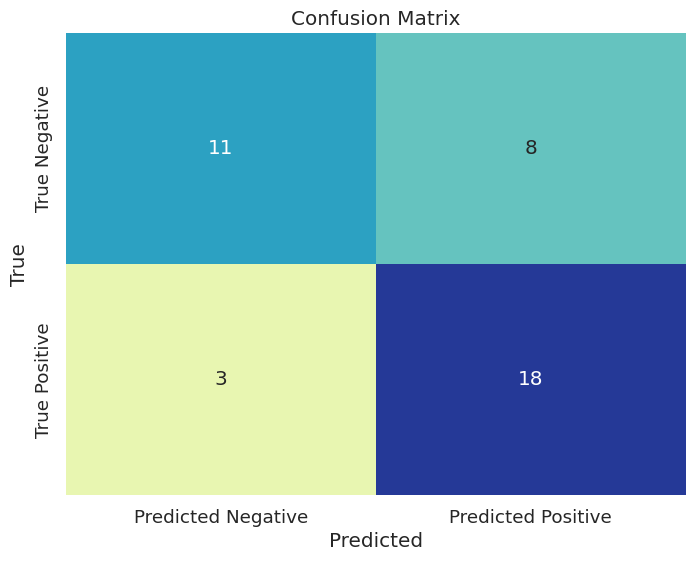

In [ ]:
# Assuming x_valid contains the preprocessed validation frames and y_valid contains the corresponding true labels (0 or 1)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Make predictions on the validation data
y_pred = model.predict(x_valid)

# Apply a threshold to the predicted probabilities to convert them into binary predictions
threshold = 0.14
y_pred_binary = (y_pred > threshold).astype(int)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_valid, y_pred_binary)

# Visualize the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size if needed
cmap = sns.color_palette("YlGnBu")
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap, cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


2/2 [==============================] - 1s 118ms/step


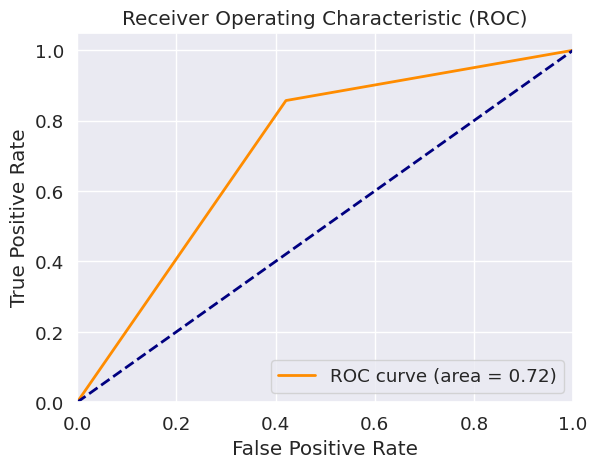

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Make predictions on the validation data
y_pred = model.predict(x_valid)

# Apply a threshold to the predicted probabilities to convert them into binary predictions
threshold = 0.1419


y_pred_binary = (y_pred > threshold).astype(int)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_binary)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()
